In [ ]:
# Core libraries
import os
import glob
import numpy as np

# Audio processing
import librosa

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# Ensure TensorFlow is available
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow
    import tensorflow as tf

# Neural network modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.1 MB/s eta 0:00:00


In [ ]:

from google.colab import files

# Upload ZIP file(s)
uploaded = files.upload()


KeyboardInterrupt: 

In [23]:
import os
import zipfile

# Define source zip files and their destination directories
archives = {
    "Audio_Speech_Actors_01-24.zip": "data/Audio_Speech_Actors_01-24",
    "Audio_Song_Actors_01-24.zip": "data/Audio_Song_Actors_01-24"
}

# Create the base directory if not already present
if not os.path.exists("data"):
    os.mkdir("data")

# Process each zip file
for archive_name, target_dir in archives.items():
    if os.path.isfile(archive_name):
        print(f"Unzipping '{archive_name}' into '{target_dir}'...")
        os.makedirs(target_dir, exist_ok=True)
        with zipfile.ZipFile(archive_name, 'r') as archive:
            archive.extractall(target_dir)
        print(f"Extraction completed: {archive_name}")
    else:
        print(f"Missing file: {archive_name}")


Unzipping 'Audio_Speech_Actors_01-24.zip' into 'data/Audio_Speech_Actors_01-24'...
Extraction completed: Audio_Speech_Actors_01-24.zip
Unzipping 'Audio_Song_Actors_01-24.zip' into 'data/Audio_Song_Actors_01-24'...
Extraction completed: Audio_Song_Actors_01-24.zip


In [31]:
# Emotion mapping based on RAVDESS labels
EMOTIONS = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}
import os

def get_ravdess_files(directory, selected_emotions):
    emotion_map = {
        "01": "neutral",
        "02": "calm",
        "03": "happy",
        "04": "sad",
        "05": "angry",
        "06": "fearful",
        "07": "disgust",
        "08": "surprised"
    }

    file_paths = []
    labels = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                # Example filename format: 03-01-05-01-02-01-12.wav
                parts = file.split("-")
                if len(parts) >= 3:
                    emotion_code = parts[2]
                    emotion = emotion_map.get(emotion_code)
                    if emotion in selected_emotions:
                        file_paths.append(os.path.join(root, file))
                        labels.append(emotion)

    return file_paths, labels


import os

def load_audio_paths(base_path, target_emotions):
    """
    Traverses RAVDESS dataset and retrieves .wav files with desired emotions.

    Args:
        base_path (str): Root directory to search within.
        target_emotions (list): Emotions to include.

    Returns:
        tuple: (list of file paths, list of labels)
    """
    collected_paths = []
    emotion_labels = []

    # RAVDESS encodes emotion as the 3rd value when split by '-'
    code_to_emotion = {
        1: "neutral",
        2: "calm",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fearful",
        7: "disgust",
        8: "surprised"
    }

    for dirpath, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(".wav"):
                try:
                    parts = file.split("-")
                    emotion_id = int(parts[2])
                    emotion = code_to_emotion.get(emotion_id)
                    if emotion in target_emotions:
                        full_path = os.path.join(dirpath, file)
                        collected_paths.append(full_path)
                        emotion_labels.append(emotion)
                except Exception:
                    continue  # Skip malformed filenames

    print(f"🔍 Found {len(collected_paths)} audio files in '{base_path}'")
    return collected_paths, emotion_labels


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def assess_model_performance(trained_model, test_data, test_labels, emotion_labels):
    """
    Evaluates the trained model and prints a classification summary.
    """
    test_loss, test_accuracy = trained_model.evaluate(test_data, test_labels, verbose=0)
    print(f"\n📊 Evaluation Accuracy: {test_accuracy:.2f}")

    predicted_probs = trained_model.predict(test_data)
    predicted_classes = np.argmax(predicted_probs, axis=1)
    actual_classes = np.argmax(test_labels, axis=1)

    print("\n🧾 Detailed Classification Report:")
    print(classification_report(actual_classes, predicted_classes, target_names=emotion_labels))


def visualize_training(history_obj, model_instance=None, test_features=None, test_targets=None, label_names=None):
    """
    Plots training accuracy/loss and optionally displays confusion matrix.
    """
    # --- Accuracy plot ---
    plt.figure(figsize=(8, 4))
    plt.plot(history_obj.history['accuracy'], label='Training')
    plt.plot(history_obj.history['val_accuracy'], label='Validation')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("accuracy_visual.png")
    plt.show()
    plt.close()

    # --- Loss plot ---
    plt.figure(figsize=(8, 4))
    plt.plot(history_obj.history['loss'], label='Training Loss')
    plt.plot(history_obj.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_visual.png")
    plt.show()
    plt.close()

    # --- Confusion Matrix ---
    if model_instance and test_features is not None and test_targets is not None and label_names:
        predictions = model_instance.predict(test_features)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(test_targets, axis=1)

        matrix = confusion_matrix(true_classes, predicted_classes)
        plt.figure(figsize=(9, 7))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=label_names, yticklabels=label_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig("confusion_matrix_visual.png")
        plt.show()
        plt.close()


In [26]:
def generate_augmented_variants(audio_path, sample_rate=22050):
    """
    Generates several augmented versions of the input audio file.
    """
    signal, _ = librosa.load(audio_path, sr=sample_rate)
    augmented_signals = []

    # 1. Add Gaussian white noise
    white_noise = 0.005 * np.random.randn(len(signal))
    noisy_signal = signal + white_noise
    augmented_signals.append(noisy_signal)

    # 2. Apply pitch shifting (raise pitch)
    pitched_signal = librosa.effects.pitch_shift(signal, sr=sample_rate, n_steps=2)
    augmented_signals.append(pitched_signal)

    # 3. Speed up the audio
    faster_signal = librosa.effects.time_stretch(signal, rate=1.25)
    augmented_signals.append(faster_signal[:len(signal)])

    # 4. Slow down the audio
    slower_signal = librosa.effects.time_stretch(signal, rate=0.8)
    if len(slower_signal) < len(signal):
        slower_signal = np.pad(slower_signal, (0, len(signal) - len(slower_signal)), mode='constant')
    else:
        slower_signal = slower_signal[:len(signal)]
    augmented_signals.append(slower_signal)

    return augmented_signals


def compute_mfcc_features(audio_path, sample_rate=16000, num_mfcc=40):
    """
    Extracts MFCC feature array from a single audio file.
    """
    waveform, _ = librosa.load(audio_path, sr=sample_rate)
    mfcc_features = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=num_mfcc)
    return mfcc_features.T  # Shape: (time_steps, num_mfcc)


In [27]:
def train_model(model, X_train, y_train, epochs=30, batch_size=20):
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size)
    return history


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Masking, BatchNormalization

def create_hybrid_cnn_lstm(input_dims, output_classes):
    """
    Constructs and compiles a CNN + LSTM model for sequence classification.

    Args:
        input_dims (tuple): Shape of input data (timesteps, features).
        output_classes (int): Number of output classes.

    Returns:
        Compiled Keras model.
    """
    print("🔧 Building hybrid CNN-LSTM model...")

    model = Sequential()

    # Initial masking for padded input
    model.add(Masking(mask_value=0.0, input_shape=input_dims))

    # 🎛️ Convolutional layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # 🔁 Recurrent layers
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(rate=0.3))

    model.add(LSTM(units=64))
    model.add(Dropout(rate=0.4))

    # 🧠 Dense layers
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Dense(units=output_classes, activation='softmax'))

    # ⚙️ Compilation
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [29]:
from tensorflow.keras.callbacks import EarlyStopping

def run_training_session(model_instance, train_data, train_labels, total_epochs=30, batch_sz=32):
    """
    Trains the given model on training data with validation split.

    Args:
        model_instance: Compiled Keras model to train.
        train_data (ndarray): Input features.
        train_labels (ndarray): Corresponding labels.
        total_epochs (int): Number of training epochs.
        batch_sz (int): Batch size for training.

    Returns:
        History object containing training metrics.
    """
    # Optional: Add early stopping (currently not used)
    # early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history_log = model_instance.fit(
        train_data,
        train_labels,
        validation_split=0.2,
        epochs=total_epochs,
        batch_size=batch_sz
        # ,callbacks=[early_stop]  # Can enable later if needed
    )

    return history_log


In [32]:
import pandas as pd
import numpy as np
import librosa

import tensorflow as tf

# 🔽 Feature extractor for augmented audio
def extract_features_from_signal(signal, sr=22050):
    if len(signal) < 2048:
        return np.zeros((1, 40))  # safe fallback
    try:
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
        return mfcc.T
    except Exception as e:
        print(f"⚠️ Feature extraction error: {e}")
        return np.zeros((1, 40))

# 🧠 Original extractor from file
def extract_features(file_path, sr=22050, n_mfcc=40):
    try:
        y, _ = librosa.load(file_path, sr=sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return mfcc.T
    except Exception as e:
        print(f"⚠️ Error loading {file_path}: {e}")
        return np.zeros((1, n_mfcc))

# 🔁 Augment every training file
def augment_audio(file_path):
    try:
        y, sr = librosa.load(file_path)
        pitch_shifted = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=2)
        speed_changed = librosa.effects.time_stretch(y, rate=1.1)
        noisy = y + 0.005 * np.random.randn(len(y))
        return [pitch_shifted, speed_changed, noisy]
    except Exception as e:
        print(f"⚠️ Augmentation error for {file_path}: {e}")
        return []

# 📁 Step 1: Load Data
SPEECH_DIR = "data/Audio_Speech_Actors_01-24"
SONG_DIR = "data/Audio_Song_Actors_01-24"
SELECTED_EMOTIONS = ["happy", "sad", "angry", "calm", "fearful","surprised","disgust","neutral"]

file_paths_speech, labels_speech = get_ravdess_files(SPEECH_DIR, SELECTED_EMOTIONS)
file_paths_song, labels_song = get_ravdess_files(SONG_DIR, SELECTED_EMOTIONS)

file_paths = file_paths_speech + file_paths_song
labels = labels_speech + labels_song

# 🧱 Step 2: Create DataFrame & Split
df = pd.DataFrame({'file': file_paths, 'label': labels})
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# ⚖️ Step 3: Balance Training Data Only
max_count = df_train['label'].value_counts().max()
df_train_balanced = df_train.groupby('label').apply(
    lambda x: resample(x, replace=True, n_samples=max_count, random_state=42)
).reset_index(drop=True)

# 🎯 Step 4: Feature Extraction with augmentation (⏳ takes time)
print("🔄 Extracting features and applying augmentation to ALL training data...")
X_train, y_train = [], []

for _, row in df_train_balanced.iterrows():
    path, label = row['file'], row['label']

    # Original
    feat = extract_features(path)
    X_train.append(feat)
    y_train.append(label)

    # Augmented
    for aug in augment_audio(path):
        feat_aug = extract_features_from_signal(aug)
        X_train.append(feat_aug)
        y_train.append(label)

# 🎯 Extract test features (no augmentation)
X_test = [extract_features(f) for f in df_test['file']]
y_test = df_test['label'].tolist()

# 📏 Step 5: Pad Sequences
X_train = pad_sequences(X_train, padding='post', dtype='float32')
X_test = pad_sequences(X_test, padding='post', dtype='float32')

# 🔐 Step 6: Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded)



/tmp/ipython-input-32-3157733288.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_balanced = df_train.groupby('label').apply(


🔄 Extracting features and applying augmentation to ALL training data...


🔧 Building hybrid CNN-LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.1909 - loss: 1.9578 - val_accuracy: 0.0000e+00 - val_loss: 4.7008
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3243 - loss: 1.6449 - val_accuracy: 0.0000e+00 - val_loss: 5.2521
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4171 - loss: 1.4688 - val_accuracy: 0.0000e+00 - val_loss: 5.6028
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4791 - loss: 1.3684 - val_accuracy: 0.0000e+00 - val_loss: 5.8329
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5339 - loss: 1.2542 - val_accuracy: 0.0000e+00 - val_loss: 5.9339
Epoch 6/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5895 - loss: 1.1333 - val_accuracy: 0.0000e+00 - val_loss: 6.3814
Epoch 7/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6230 - loss: 1.0147 - val_accuracy: 0.0000e+00 - val_loss: 6.5871
Epoch 8/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


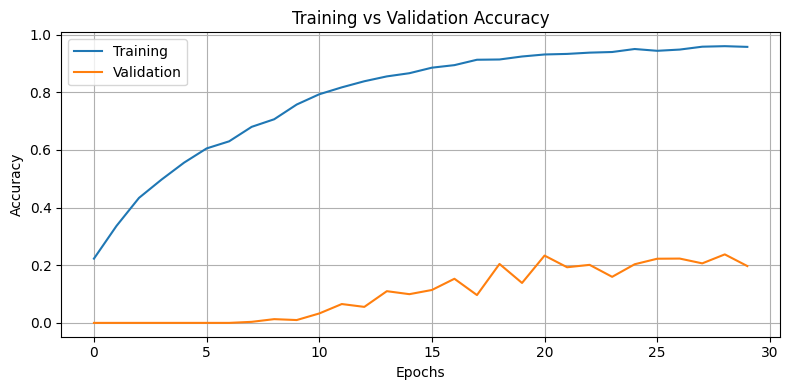

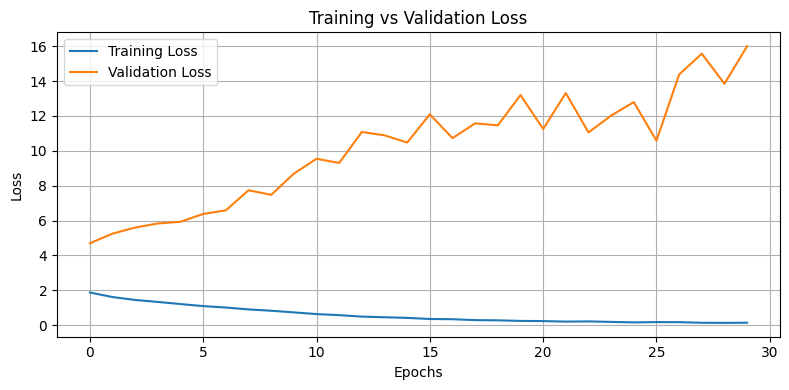

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [33]:
# 🧠 Phase 1: Model Setup & Training
input_dims = X_train.shape[1:]
emotion_model = create_hybrid_cnn_lstm(input_dims, output_classes=len(label_encoder.classes_))

training_log = run_training_session(
    model_instance=emotion_model,
    train_data=X_train,
    train_labels=y_train_onehot
)

# 📊 Phase 2: Evaluation & Visualization
assess_model_performance(
    trained_model=emotion_model,
    test_data=X_test,
    test_labels=y_test_onehot,
    emotion_labels=label_encoder.classes_
)

visualize_training(
    history_obj=training_log,
    model_instance=emotion_model,
    test_features=X_test,
    test_targets=y_test_onehot,
    label_names=label_encoder.classes_
)
